# The code here follows examples and exercises from the ISL Book Ch03 where LinReg is discussed

The Formula for Single Linear Regression is

# $  Y = \beta_{0} + (\beta_{1}X_{1})  +   \epsilon $

To calculate the Beta parameters we can use these formulas:

# $ \beta_{1} = \sum( X_{i} - \bar{X}) ( Y_{i} - \bar{Y} ) / \sum( X_{i} - \bar{X})^2   $

# $ \beta_{0} =  \bar{Y} -  \beta_{1}\bar{X}   $

The code in most of the cells in this notebook show how simple code (in Julia) that reproduces some of the examples, tables, and exercises from CH03. The code at the end of the notebook shows how to write the formulas as functions in Julia for the single variable case.  Sinte the multi-variable case can be written using the Pseudo-Inverse Matrix, the exercise of writing such a function is trivial once we follow the cells in this notebook  



# The code here follows examples, exercises from ISL Book Ch03 where LinReg is discussed

The formula for Multiple LinReg is 

# $  Y = \beta_{0} + (\beta_{1}X_{1})  +  (\beta_{2}X_{2})   + . . . +  (\beta_{p}X_{p}) + \epsilon $


The beta coefficients that maximize Y given X need to be obtained. For the multi-variable case, x[N,P]  is a matrix and y[N] is a vector. The betas are obtained using the Moore-Penrose Pseudo Matrix. 

Afterwards parameters such as $ R^{2},  $ RSS, RSE, F-Statistics, etc are obtained  to measure the accuracy of the values obtained.


FileName = "isl_ch03_linReg.jl.ipynb"


In [1]:
import Pkg

# coment out once pkgs are loaded
#=
Pkg.add("CSV")
Pkg.add("EzXML")
Pkg.add("DataFrames")
Pkg.add("CUDA")
Pkg.add("BenchmarkTools")
Pkg.add("GLM")
Pkg.add("Distributions")
Pkg.add("Plots")
=#

using GLM
using Distributions # not included in the GLM Pkg

using DelimitedFiles
using CSV
using EzXML
using Dates
using DataFrames

# using MLDatasets 
# https://juliaml.github.io/MLDatasets.jl/stable/
# This Pkg is part of the JuliaML community. 
# It provides access to several datasets (Graphs, Text, Vision, Miscellaneous}  

using CUDA

using BenchmarkTools
using LinearAlgebra
using Statistics
	



In [3]:

const islCh3Dir = "/hm2/code/julia/LearnGLM//"

# Dir where data resides
const datDir = "/hm2/Data/ML_Data/ISL_Data/"
adData = string( datDir, "AdvertisingData.csv")



"/hm2/Data/ML_Data/ISL_Data/AdvertisingData.csv"

In [4]:
function ReadCSVFile( fileName::String, addOnes="NO" )::DataFrame

	if addOnes== "NO"
		df = DataFrame(CSV.File( fileName))
		return df
	end

	if addOnes== "YES"
		df1 = DataFrame(CSV.File( fileName))
		nr = nrow(df1)
		#create a df of size (nr, 1) with ones in first column
		df2 = DataFrame(ones(nr, 1), :auto)
		# return a df with ones and the content from the CSV file
		df = hcat(df2, df1)
		#rename firt column as "x0" to be consistent woth regression
		n = names(df)
		rename!(df, n[1] => "x0")
		return df
	end

end

function DfConfig( df::DataFrame, cv::Vector) :: DataFrame
	return select( df, cv)
end



DfConfig (generic function with 1 method)

In [5]:
#=
          function CalcF(n, p, stv)
  Calculate the LinReg parameters for RSE, R^2, F-Statistic.
  n is the number of rows in the data; 
  p is the number of columns
  stv is the StatsModel obj obtained from calling

     stv = lm(@formula(Yv ~ Xm ), Df) 

  where Yv => yVector; Xm => xMatrix;  Df => DataFrame with [Yv, Xm]    
=#
function CalcF(n, p, stv)

  #print("p = ", p)
  #print("TypeOf stv = ", typeof(stv))

   p = p - 1         # the actual number of params minus the col for X0
   dfm = p-1         # DFM is the Corrected Degrees of Freedom for the Model
   dfe = n-p         # DFE is the Degrees of Freedom for the Error 

   ev  = stv.model.rr.y .- stv.model.rr.mu   # this is a vector with err(i) = y(i) - y_cap(i)
   ev2 = ev .^ 2                             # this is a vector with the values of ev squared
   sse = sum( ev2 )                          # sse = sum(i..n)[ y(i) - y_cap(i)] ^ 2

   y_ave = sum( stv.model.rr.y) / n 
   ssm = stv.model.rr.mu .- y_ave           # y_cap(i) - y_ave
   ssm = ssm .^ 2 
   ssm = sum(ssm)                          # ssm = sum(i..n)[ y_cap(i) - y_ave] ^ 2 

   tss =  stv.model.rr.y .- y_ave
   tss = tss .^2
   tss = sum(tss)                           # tss = sum(i..n) [ y(i) - y_ave ] ^ 2

   ### calculate R^2
   r2 = 1.0 - (sse / tss)
   println("\n\nR2  = ", r2)

   ###calculate RSE
   rse = (sse * ( 1/(n-2) )) ^ 0.5
   println("RSE = ", rse)

   ### calculate F-Statistic
   f = (ssm/dfm)/ (sse/dfe)
   println("F   = ", f)

end


CalcF (generic function with 1 method)

Estimate the single regression coefficients for the advertising data set in ISL Book Chapter 3 to reproduce the values 
in table 3.1 (pp.68), table 3.2 (pp.69) and tables 3.3a and 3.3b (pp. 72)

#  sales = β0  +  β1 × TV  +   ε
        
#  sales = β0  +  β2 × radio +  ε
         
#  sales = β0  +  β3 × newspaper  +  ε  

In [6]:
df    = ReadCSVFile("/hm2/Data/ML_Data/ISL_Data/AdvertisingData.csv", "NO")

df1   = DfConfig( df, [1] )                     # get Ones
dft   = DfConfig( df, [2] )                     # get TV data
dfr   = DfConfig( df, [3] )                     # get Radio data
dfn   = DfConfig( df, [4] )                     # get Newspaper data
dfs   = DfConfig( df, [5] )                     # get Sales data
dfa   = hcat( df1, dft, dfr, dfn, dfs)          # set a DF with Y and all the columns in X 

println("The columns names in the data set are ", names(dfa))

stv = lm(@formula(Sales ~ TV ), dfa) # stv is the OLS from the GLM for Sales Given TV
# print("TypeOf stv = ", typeof(stv))

println("\n\n     Sales Given TV (Table 3.1 from pp. 68) \n\n")
println(stv)

n = nrow(dfa)     # nRows
p = 3             # Cols = {ones, TV, Sales}
## F-statistic = (SSM/DFM) / (SSE/DFE)
CalcF(n, p, stv)

### This formula for F-Statistic ( eq. 3.23 from the ISLR2 Book is wrong !!! )
#fn = (tss - sse) / p 
#fd = sse/(n - p - 1)
#f2 = fn / fd 
#println("Wrong F = ", f2)

# Reproduce Table 3.3a in pp. 72
str = lm(@formula(Sales ~ Radio ), dfa) # str is the OLS from the GLM for Sales Given Radio
println("\n     Sales Given Radio (Table 3.3a) \n")
println(str)

# Reproduce Table 3.3b in pp. 72
stn = lm(@formula(Sales ~ Newspaper ), dfa) # str is the OLS from the GLM for Sales Given Newspaper
println("\n     Sales Given Newspaper (Table 3.3b) \n")
println(stn)

 

The columns names in the data set are ["RecordNumber", "TV", "Radio", "Newspaper", "Sales"]


     Sales Given TV (Table 3.1 from pp. 68) 


StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Sales ~ 1 + TV

Coefficients:
─────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────────
(Intercept)  7.03259    0.457843    15.36    <1e-34  6.12972    7.93547
TV           0.0475366  0.00269061  17.67    <1e-41  0.0422307  0.0528426
─────────────────────────────────────────────────────────────────────────


R2  = 0.611875050850071
RSE = 3.2586563686504624
F   = 312.1449943727118

     Sales Given Radio (Table 3.3a) 

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Fl

Estimate the regression coefficients for the advertising data set

#   sales = β0  +  β1 × TV  +  β2 × radio  +  β3 × newspaper   +   ε  

In [7]:
#=
  The code in this cell reproduces  Table 3.4, pp 74, from the ISLR_V2 book.
    The equation relating the parameters

              y = b0 + b1*TV + b2*Radio + b3*Newspaper

    The coefficients found by the code are the same as in Table 3.4.
    
    The function calls the function GLM.lm from the GLM module.
    
      ols = lm(@formula(Sales ~ TV + Radio + Newspaper), df) 

    ols is a StatsModels.TableRegressionModel obj contain the following members:
    
    ols.model => Object that contains members
    ols.mf    => Object that contains the "Model Frame" which looks like a specialized data frame
    ols.mm    +> ModelMatrix{T}

    ols.model.rr returns a GLM.Resp object. Its members are:
    ols.model.rr.mu: mean response vector or fitted value, or y_cap(i)
    ols.model.rr.offset:  
    ols.model.rr.wts: optional vector of prior frequency weights for observations
    ols.model.rr.y: The original values in the response vector, or y(i) (dependent variable)
=#

df = ReadCSVFile("/hm2/Data/ML_Data/ISL_Data/AdvertisingData.csv", "NO")
ols = lm(@formula(Sales ~ TV + Radio + Newspaper), df)
println(ols)

### F-statistic = (SSM/DFM) / (SSE/DFE)
n = nrow(df)
p = ncol(df)

## F-statistic = (SSM/DFM) / (SSE/DFE)
CalcF(n, p, ols)

### The formula for F-Statistic ( eq. 3.23 from the ISLR2 Book is wrong !!! )


StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Sales ~ 1 + TV + Radio + Newspaper

Coefficients:
────────────────────────────────────────────────────────────────────────────
                   Coef.  Std. Error      t  Pr(>|t|)   Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────────
(Intercept)   2.93889     0.311908     9.42    <1e-16   2.32376    3.55402
TV            0.0457646   0.0013949   32.81    <1e-80   0.0430137  0.0485156
Radio         0.18853     0.00861123  21.89    <1e-53   0.171547   0.205513
Newspaper    -0.00103749  0.00587101  -0.18    0.8599  -0.012616   0.010541
────────────────────────────────────────────────────────────────────────────


R2  = 0.8972106381789521
RSE = 1.6769760888385674
F   = 570.2707036590923


In [8]:
#= 

The code in this cell reproduces Table 3.6, pp 76, from the ISLR_V2 book.
The Lin Reg equation is
 
          y = b0 + b1*TV + b2*Radio + b3*Newspaper
 
The code here calls function GLM.lm from the GLM module.
     
      ols = lm(@formula(Sales ~ TV + Radio + Newspaper), df) 
 
ols is an obj of type StatsModels.TableRegressionModel. 
Details are described in the comments for AdvertisingDataTable34()

F-Test for Lin reg
  
   F-statistic = (SSM/DFM) / (SSE/DFE)
  
   SSM = sum(i..n)[ y_cap(i) - y_ave    ]^2
   SSE = sum(i..n)[ y(i)     - y_cap(i) ]^2    = RSS
   TSS = sum(i..n)[ y(i)     - y_ave    ] ^ 2
 
   n = number of nRows
   p = number of params (not counting X0)
   DFM = p-1
   DFE = n-p
 
   y_cap(i) can be obtained from ols.model.rr.mu
   y(i)     can be otained from      ols.model.rr.y
   y_ave    is calculated from y(i)

  To calculate R^2:  R^2 = 1.0 - (SSE / TSS)
  To calculate RSE:  ( RSS / (n-2) )^2
 
  NOTE: The code here reproduces the same values as those of table 3.6. 
  NOTE: Eq. 3.23 for F-Test in the ISL book is wrong ! ! !   
 
  Correct Formula:  http://facweb.cs.depaul.edu/sjost/csc423/documents/f-test-reg.htm

 =#

  df    = ReadCSVFile("/hm2/Data/ML_Data/ISL_Data/AdvertisingData.csv", "NO")

  df1   = DfConfig( df, [1] )     # get Ones
  dft   = DfConfig( df, [2] )     # get TV data
  dfr   = DfConfig( df, [3] )     # get Radio data
  dfn   = DfConfig( df, [4] )     # get Newspaper data
  dfs   = DfConfig( df, [5] )     # get Sales data
  dfy   = hcat( df1, dft, dfr, dfn, dfs) 
  ols   = lm(@formula(Sales ~ TV + Radio + Newspaper), dfy)
  # println(ols)

  ### F-statistic = (SSM/DFM) / (SSE/DFE)
  n = nrow(dfy)
  p = ncol(dfy)

  CalcF(n, p, ols)

  ## The formula for F-Statistic ( eq. 3.23 from the ISLR2 Book is wrong !!! )





R2  = 0.8972106381789521
RSE = 1.6769760888385674
F   = 570.2707036590923


In [10]:
#=
The code in this cell reproduces tables 3.7, 3.8 from the ISL Book.
The code uses the Credit dataset

=#


fileName = "/hm2/Data/ML_Data/ISL_Data/Credit.csv"
df = ReadCSVFile(fileName, "YES")

@show(names(df))

# names(df) = ["x0", "Income", "Limit", "Rating", "Cards", "Age", "Education", "Own", "Student", "Married", "Region", "Balance"]


# keep only x0, own{yes/no => 1/0] and balance to produce table 3.7 from the ISL book V2, pp. 85
# keep only x0, Own, Balance
v = [1, 8, 12]
dft = DfConfig(df, v)
replace!(dft.Own, "Yes" => "1")
replace!(dft.Own, "No" => "0")

# Replace the elements of type string that contain "0" or "1" with a number
# so that linear regression coould be computed on this data.
dft[!, :Own] = parse.(Int,dft[!, :Own])

# PrettyPrint(dft)

ols = lm(@formula(Balance ~ Own), dft)
println(ols)

#= The code produces the values below. Compare to table 3.7, pp 85. I added the "p-value" 
in the title of the coefficients for clarification

                                Coefficients:
              Coef.     Std. Error      t  Pr(>|t|)     p-value     Lower 95%   Upper 95%
(Intercept)  509.803      33.1281         15.39           <1e-41     444.675       574.931
Own           19.7331     46.0512         0.43            0.6685   -70.8009       110.267
=#

#= The column "Region" has values{South, West, East}. The code below produces Table 3.8.
There are three independent variables { X0, rSouth, rWest } with values {1,0} when the
element in Region South/West values.
=#

v = [1, 12, 13]
df1 = DfConfig( df, [1] )     # get Ones
dfr = DfConfig( df, [11] )    # get Region
dfb = DfConfig( df, [12] )    # get Balance

dfs = copy( dfr ) # this is DF for South 
dfw = copy( dfr ) 

replace!(dfs.Region, "South" => "1")
replace!(dfs.Region, "West"  => "0")
replace!(dfs.Region, "East"  => "0")
n = names(dfs)
rename!(dfs, n[1] => "South")

replace!(dfw.Region, "West"  => "1")
replace!(dfw.Region, "South" => "0")
replace!(dfw.Region, "East"  => "0")
n = names(dfw)
rename!(dfw, n[1] => "West")


# configure a df with ones, South, West and Balance
df = hcat(df1, dfs, dfw, dfb)
#rename firt column as "x0" to be consistent woth regression
# n = names(df)
#rename!(df, n[1] => "x0")
#rename!(df, n[2] => "South")
#rename!(df, n[3] => "West")

ols = lm(@formula(Balance ~ South + West), df)
println(ols)


names(df) = ["x0", "Income", "Limit", "Rating", "Cards", "Age", "Education", "Own", "Student", "Married", "Region", "Balance"]
StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Balance ~ 1 + Own

Coefficients:
────────────────────────────────────────────────────────────────────────
                Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────
(Intercept)  509.803      33.1281  15.39    <1e-41   444.675     574.931
Own           19.7331     46.0512   0.43    0.6685   -70.8009    110.267
────────────────────────────────────────────────────────────────────────
StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Balance ~ 1 + South + West

Coefficients:
──

In [24]:
#=
Code in this cell reproduces Table 3.9, pp 89, from the ISLR_V2 book.
The equation is 

    y = b0 + b1*TV + b2*Radio + b3*Radio*TV

The coefficients produced here are
                  Coef.  Std. Error      t  Pr(>|t|)    Lower 95%   Upper 95%
(Intercept)  6.75022     0.247871    27.23    <1e-67  6.26138      7.23906
TV           0.0191011   0.00150415  12.70    <1e-26  0.0161347    0.0220675
Radio        0.0288603   0.00890527   3.24    0.0014  0.0112979    0.0464228
RTV          0.00108649  5.24204e-5  20.73    <1e-50  0.000983114  0.00118988

which are the same as in table 3.9  ;->

The code produces the same value as the book for R2 = 96.8
=#

df = ReadCSVFile(adData, "NO")
@show(names(df))
# names(df) = ["x0", "RecordNumber", "TV", "Radio", "Newspaper", "Sales"]

# Ones,TV,Radio,Newspaper,Sales
df1   = DfConfig( df, [1] )     # get Ones
dft   = DfConfig( df, [2] )     # get TV data
dfr   = DfConfig( df, [3] )     # get Radio data
dfs   = DfConfig( df, [5] )     # get Sales data
rtv = dft[:,1] .* dfr[:,1]      # this is a vector with the product of R * TV data
dfrt = DataFrame(RTV = rtv)     # this is a dataframe with the RTV product

# PrettyPrint(dfrt)
n = names(dfrt)
rename!(dfrt, n[1] => "RTV")

dfy = hcat( df1, dft, dfr, dfrt, dfs) 
n = names(dfy)

println("Names = " ,n)

ols = lm(@formula(Sales ~ TV + Radio + RTV), dfy)
println(ols)

### Compute F-Statistic = (SSM/DFN) / (SSE/DFE) for first model
### Given by   y1 = b0 + b1*HP  

n = nrow(dfy)
p = ncol(dfy)
## F-statistic = (SSM/DFM) / (SSE/DFE)
CalcF(n, p, ols)



names(df) = ["RecordNumber", "TV", "Radio", "Newspaper", "Sales"]
Names = ["RecordNumber", "TV", "Radio", "RTV", "Sales"]
StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Sales ~ 1 + TV + Radio + RTV

Coefficients:
─────────────────────────────────────────────────────────────────────────────
                  Coef.  Std. Error      t  Pr(>|t|)    Lower 95%   Upper 95%
─────────────────────────────────────────────────────────────────────────────
(Intercept)  6.75022     0.247871    27.23    <1e-67  6.26138      7.23906
TV           0.0191011   0.00150415  12.70    <1e-26  0.0161347    0.0220675
Radio        0.0288603   0.00890527   3.24    0.0014  0.0112979    0.0464228
RTV          0.00108649  5.24204e-5  20.73    <1e-50  0.000983114  0.00118988
─────────────────────────────────────────────────────────────────────────────


R2  = 0.9677905498482523
RSE = 0.9

In [26]:

#=
    The code is this cell reproduces Table 3.10, pp 92, from the ISLR_V2 book.  
    
    The name of the columns in the data file are

         "ones","mpg","cylinders","displacement","horsepower","weight","acceleration","year","origin","name"

    This is an example of using standard Linear Regression with polynomial terms.
    Here the HP parameter is used twice, as HP and HP*HP. This is done because the
    first take on LinReg, using all the params to estimate mpg. When looking at a 
    chart of mpg vs hp, it appears that a quadratic relashionship is a better fit
    than a linear fit. The code here explores if this is true,  
      
    The equation used to generate the values in table 3.10 is 

    y = b0 + b1*HP + b2*HP*HP
    
    where y is mpg and  HP is Horse Power. 

    The coefficients found by this code are the same as in table 3.10.

    According to the text, the R^2 for the quadratic fit is 0.688 while the linear fit is 
    0.606. I need to confirm these numbers by using eq. 3.17 form ISL text !!!. 
    
    I used the formulas summarized on the section  "Interpreting Results" of my 
    Machine Learning notes. Write functions for RSS, TSS, DFM, DFE, R^2 in the file
    LinearRegression.jl 

=#

    df = ReadCSVFile("/hm2/Data/ML_Data/ISL_Data/Auto.csv", "YES")
    @show(names(df))
   # names(df) = ["mpg", "cylinders", "displacement", "horsepower", "weight", "acceleration", "year", "origin", "name"]

    df1   = DfConfig( df, [1] )     # get Ones
    dfh   = DfConfig( df, [5] )     # get horse power
    dfm   = DfConfig( df, [2] )     # get mpg
    hp2   = dfh[:,1] .* dfh[:,1]    # this is a vector with the product of HP*HP
    dfp2  = DataFrame(HP2 = hp2)     # this is a dataframe with that product 
 
    # PrettyPrint(dfrt)
    n = names(dfp2)
    rename!(dfp2, n[1] => "HP2")
 
    dfy = hcat( df1, dfh, dfp2, dfm) 
    n = names(dfy)
 
    println("Names = " ,n)
 
    ols = lm(@formula(mpg ~ horsepower + HP2), dfy)
    println(ols)

 
    ### Compute F-Statistic = (SSM/DFN) / (SSE/DFE) for first model
    ### Given by   y1 = b0 + b1*HP  

    n = nrow(dfy)
    p = ncol(dfy)
    CalcF(n, p, ols)

    

names(df) = ["x0", "mpg", "cylinders", "displacement", "horsepower", "weight", "acceleration", "year", "origin", "name"]
Names = ["x0", "horsepower", "HP2", "mpg"]
StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

mpg ~ 1 + horsepower + HP2

Coefficients:
──────────────────────────────────────────────────────────────────────────────────
                      Coef.  Std. Error       t  Pr(>|t|)   Lower 95%    Upper 95%
──────────────────────────────────────────────────────────────────────────────────
(Intercept)       19.5941      0.983635   19.92    <1e-56   17.6585     21.5297
horsepower: 102    0.405882    4.17321     0.10    0.9226   -7.80626     8.61802
horsepower: 103    0.705882    4.17321     0.17    0.8658   -7.50626     8.91802
horsepower: 105    0.905882    1.52912     0.59    0.5540   -2.10316     3.91493
horsepower: 107    1.40588     4.17321     

# Single Linear Regression Formula

# $  Y = \beta_{0} + (\beta_{1}X_{1})  +   \epsilon $

To calculate the Beta parameters we can use these formulas:

# $ \beta_{1} = \sum( X_{i} - \bar{X}) ( Y_{i} - \bar{Y} ) / \sum( X_{i} - \bar{X})^2   $

# $ \beta_{1} = \frac{ \sum( X_{i} Y_{i} )  - \bar{X} \bar{Y} } {\sum(X_{i}^2) - ( \sum(X_{i})^2 /n } $

# $ \beta_{0} =  \bar{Y} -  \beta_{1}\bar{X}   $

Functions and examples follow 

In [28]:
#= 
   The code in this cell reproduces table 3.1 from the ISL book
   
1. Obtain the beta parameters (b0, b1) for the single case of Linear Regression.
   Receive as arg df::DataFrame; extract X and yVec, both of which are Julia vectors objs 
   using standard arith operators and vector broadcasting  

2. Do calculations for the  case of Sales ~ TV only.

3. Reproduce Table 3.2 from ISL Book, where RSE, R^2 and the F_Statistic are computed

=#
function SingleLinReg( df::DataFrame)
  
   n = nrow(df)                    # get numbert of rows in data 
   dfx = DfConfig( df, [2] )
   xv  = dfx[:,1]                   # xv is a vector with TV Data
   dfy = DfConfig( df, [5] )
   yv  = dfy[:,1]                   # yv is a vector with Sales Data

   sx = 0.0; sy = 0.0; sxx = 0.0; syy = 0.0 ; sxy = 0.0
   
   for i = 1:n 
      sx  += xv[i]
      sy  += yv[i]
      sxy += xv[i] * yv[i]
      sxx += xv[i] * xv[i]
      syy += yv[i] * yv[i]
   end

   yAve = sy/n
   xAve = sx/n

   b1 = ( sxy - (sx*sy)/n) /( sxx - (sx*sx)/n)  
   b0 = ( yAve ) - b1 * ( xAve )
   println("b1 = ", b1,"   b0 = ", b0)


   # Do the F-Statistic, first using the GLM library, then by code, just to demo and verify

   df1 = DfConfig( df, [1] )        #get the "ones"
   # dfx is the TV Data
   # dfy is the Sales Data
   dfstv = hcat( df1, dfx, dfy )    #compose a DF with columns ["Ones", "TV", "Sales"] 
   dfNames = names(dfstv)

   println("Names = " ,dfNames)

   ols = lm(@formula(Sales ~ TV), dfstv)
   println(ols)

   ### Compute F-Statistic = (SSM/DFN) / (SSE/DFE) for first model
   ### Given by   y1 = b0 + b1*HP  

   n = nrow(dfstv)
   p = ncol(dfstv)

   CalcF(n, p, ols)

  
   #=
   F-Test for Lin reg
   F-statistic = (SSM/DFM) / (SSE/DFE)
   SSM = sum(i..n)[ y_cap(i) - y_ave    ]^2
   RSS = sum(i..n)[ y(i)     - y_cap(i) ]^2    = SSE
   TSS = sum(i..n)[ y(i)     - y_ave    ] ^ 2
 
   n = number of nRows
   p = number of params (not counting X0)
   DFM = p-1
   DFE = n-p
 
   y_cap(i) can be obtained from ols.model.rr.mu
   y(i)     can be otained from      ols.model.rr.y
   y_ave    is calculated from y(i)

  To calculate R^2:  R^2 = 1.0 - (SSE / TSS)
  To calculate RSE:  ( RSS / (n-2) )^2

  =#

  rss = 0.0
  for i = 1:n 
    rss += ( yv[i] - b0 - b1*xv[i] )^2
  end
  rse = sqrt(  rss/(n-2))
  
  tss = yv .- yAve         #  broadcast the operation y[i] - yAve for i=1..n
  tss = tss .^2            #  broadcast the tss[i]^2 for i=1..n
  tss = sum(tss)
  r2 = 1.0 - (rss / tss)
  println("RSE = ", rse,"  R2  = ", r2)

   return b0, b1

end


df = ReadCSVFile("/hm2/Data/ML_Data/ISL_Data/AdvertisingData.csv", "NO")

b0, b1 = SingleLinReg(df)

println("b1 = ", b1,"   b0 = ", b0)


b1 = 0.04753664043301965   b0 = 7.032593549127711
Names = ["RecordNumber", "TV", "Sales"]
StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Sales ~ 1 + TV

Coefficients:
─────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────────
(Intercept)  7.03259    0.457843    15.36    <1e-34  6.12972    7.93547
TV           0.0475366  0.00269061  17.67    <1e-41  0.0422307  0.0528426
─────────────────────────────────────────────────────────────────────────


R2  = 0.611875050850071
RSE = 3.2586563686504624
F   = 312.1449943727118
RSE = 3.2586563686504624  R2  = 0.611875050850071
b1 = 0.04753664043301965   b0 = 7.032593549127711


Names = ["HP2"]
StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

mpg ~ 1 + horsepower

Coefficients:
────────────────────────────────────────────────────────────────────────────────
                      Coef.  Std. Error      t  Pr(>|t|)   Lower 95%   Upper 95%
────────────────────────────────────────────────────────────────────────────────
(Intercept)       19.5941      0.983635  19.92    <1e-56   17.6585    21.5297
horsepower: 102    0.405882    4.17321    0.10    0.9226   -7.80626    8.61802
horsepower: 103    0.705882    4.17321    0.17    0.8658   -7.50626    8.91802
horsepower: 105    0.905882    1.52912    0.59    0.5540   -2.10316    3.91493
horsepower: 107    1.40588     4.17321    0.34    0.7364   -6.80626    9.61802
horsepower: 108   -0.594118    4.17321   -0.14    0.8869   -8.80626    7.61802
horsepower: 110    0.239216    1.37161    0.17    0.8

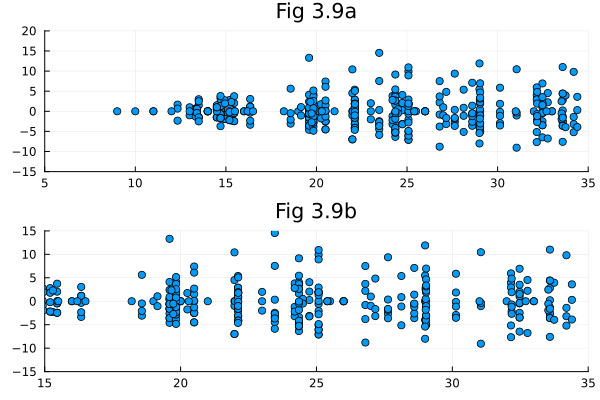

In [31]:
#=
  Code here reproduces Fig 3.9 from CH03 ISL Book, where two residual plots are produced for the Auto data set,
  involving Mileage vs HP

  The column names in the data file are

  "ones","mpg","cylinders","displacement","horsepower","weight","acceleration","year","origin","name"

  Here we use only HP to predict Mileage, thereore the equation is

          Mileage = y =  b0 + b1*HP 
  
  Residual plots are useful for identifying non-linearities. We could plot
    
    e(i) = y(i) - y_cap(i)   versus x(i)

  but following the ISL book, here we plot instead the residuals vs the fitted values y_cap(i). 
  In figs 3.9(a) and 3.9(b) there are red lines to highlight the smooth fit to the residuals 
     
    
  =#

  using Plots

  df = ReadCSVFile("/hm2/Data/ML_Data/ISL_Data/Auto.csv", "YES")
  
  df1   = DfConfig( df, [1] )     # get Ones
  dfh   = DfConfig( df, [5] )     # get horse power
  dfm   = DfConfig( df, [2] )     # get mpg
  hp2   = dfh[:,1] .* dfh[:,1]    # this is a vector with the product of HP*HP
  dfp2  = DataFrame(HP2 = hp2)     # this is a dataframe with that product 
 
  n = names(dfp2)
  rename!(dfp2, n[1] => "HP2")
  println("Names = " ,n)
 
  dfy = hcat( df1, dfh, dfp2, dfm) 
  ols = lm(@formula(mpg ~ horsepower ), dfy)
  println(ols)

  ### Compute F-Statistic = (SSM/DFN) / (SSE/DFE) for first model
  ### Given by   y1 = b0 + b1*HP  
  n = nrow(dfy)
  p = ncol(dfy)
  CalcF(n, p, ols)

  xv  = dfy[:,2]  # get HP as a vector 
  y_cap1 = ols.model.rr.mu
  ev1 = dfm[:,1]
  ev1 = ev1 .- y_cap1 

  # now do the LinReg including HP*HP
  ols = lm(@formula(mpg ~ horsepower + HP2), dfy)
  # ols = lm(@formula(mpg ~  HP2), dfy)
  y_cap2 = ols.model.rr.mu
  ev2 = dfm[:,1]
  ev2 = ev2 .- y_cap2 
 

  plot1 = scatter( y_cap1, ev1, xlim=(5,35),  ylim=(-15, 20), title="Fig 3.9a" )
  plot2 = scatter( y_cap2, ev2, xlim=(15,35), ylim=(-15, 15), title="Fig 3.9b" )
  plot3 = plot( plot1, plot2, layout = (2, 1), legend=false)


  plot3
  

# Heteroscedasticity

<b> Homoscedastic </b> is defined as data having the same finite variance along the independent variable(s). This is also known as homogeneity of variance. The complementary notion is called <b> heteroscedasticity </b>. Assuming a variable is homoscedastic when in reality it is heteroscedastic results in unbiased but inefficient point estimates and in biased estimates of standard errors, and may result in overestimating the goodness of fit as measured by the Pearson coefficient.

This condition exists when the variation in data changes in some segments of the data. The existence of heteroscedasticity is a major concern in regression analysis and the analysis of variance, because it invalidates statistical tests of significance that assume that the modeling errors have the same variance acress the independent variable(s). The figure below, which sort of reproduces Fig 3.11 from the ISL Book, shows a data set in which the variation is larger in the higher values of the x-axis.


Size of y=(500,)  Size of x=(500,)  Size of z=(500,)

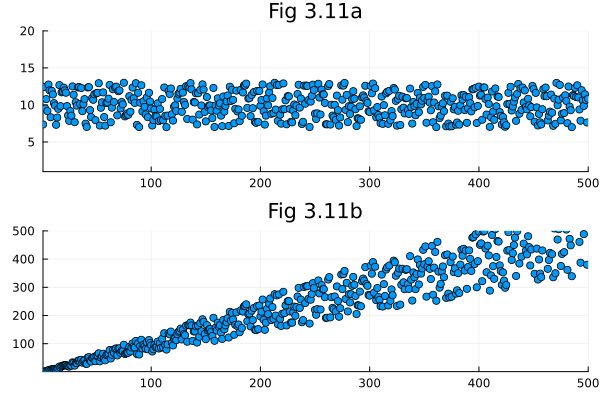

In [32]:
using Distributions
x = collect(1.0 :500)
y = rand(Uniform(7, 13), 500)
z = collect(0.001  : 0.1 : 50)
yz = y .* z

print("Size of y=", size(y)); print("  Size of x=", size(x))  ;  print("  Size of z=", size(z))

plot1 = scatter( x, y,  xlim=(1,500),  ylim=(1,20), title="Fig 3.11a" )
plot2 = scatter( x, yz, xlim=(1,500),  ylim=(1,500), title="Fig 3.11b" )
plot( plot1, plot2, layout = (2, 1), legend=false)



An F Test can be used to assess heteroskedasticity under the assumption that the errors are independent and identically distributed (i.i.d.). We can perform the test using the fitted values of the model, the predictors in the model and a subset of the independent variables.

In [33]:
df = DataFrame(X=x, Y=y)
ols = lm(@formula(Y ~ X ), df)
println(ols)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Y ~ 1 + X

Coefficients:
──────────────────────────────────────────────────────────────────────────────────
                    Coef.   Std. Error      t  Pr(>|t|)    Lower 95%     Upper 95%
──────────────────────────────────────────────────────────────────────────────────
(Intercept)  10.2231       0.153559     66.57    <1e-99   9.9214      10.5248
X            -0.000601482  0.000531148  -1.13    0.2580  -0.00164505   0.000442085
──────────────────────────────────────────────────────────────────────────────────
